## Financial Institution Fraud Detection Analysis

#### Author: Andrew Tran

## Blog Post Inspiration and Objectives

In this blog post, I was hoping to detect anamolies in Machine Learning by investigating bank fraud. It's really hard to find real-life examples of bank transactions given the risk of compromising security protocols and user confidentality agreements. Thus, after a great deal of searching, I found the following dataset from BankSim, an agent-based simulator of bank payments based on a sample of aggregated transactional data provided by a bank in Spain, which is commonly used in financial fraud-detection research due to its highly-realistic nature. With that said, let's try to analyze this topic with some Machine Learning:

## Data Preprocessing - Cleaning and Analytics

In [1]:
# Imported needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.collections import LineCollection
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
color = sns.color_palette()
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import MiniBatchKMeans, KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
import kneed
from sklearn.decomposition import PCA
plt.style.use("fivethirtyeight")

First, we will read and display the initial dataset in our file system for this blog post, downloaded from Kaggle. This dataset contains loads of valuable information such as all financial transaction information that you would typically document such as time-step of transaction, IDs of buyer and sellers, ZIP-codes of source and destination locations, amount transferred, and whether every transaction was listed as an objective fraud or legitimate (not-fraud) case.

In [2]:
# Reading and displaying the initial dataset
df = pd.read_csv("datasets/bs140513_032310.csv")
df

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0
...,...,...,...,...,...,...,...,...,...,...
594638,179,'C1753498738','3','F','28007','M1823072687','28007','es_transportation',20.53,0
594639,179,'C650108285','4','F','28007','M1823072687','28007','es_transportation',50.73,0
594640,179,'C123623130','2','F','28007','M349281107','28007','es_fashion',22.44,0
594641,179,'C1499363341','5','M','28007','M1823072687','28007','es_transportation',14.46,0


Because of the nature of the dataset's size, I will be sampling here due to computing resources on my device to perform a later DBSCAN (O(n^2) algorithm).

In [3]:
# Sampling due to computing resources on my device to perform DBSCAN (O(n^2) algorithm)
max_rows = 200000
df = df.sample(n=max_rows, random_state=42)
df

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
70803,26,'C746862122','3','M','28007','M348934600','28007','es_transportation',11.65,0
470791,146,'C1760492708','1','F','28007','M1823072687','28007','es_transportation',1.60,0
568310,172,'C1984083185','3','F','28007','M1823072687','28007','es_transportation',33.36,0
23709,9,'C1530262146','2','M','28007','M1823072687','28007','es_transportation',8.01,0
49723,19,'C1471216995','3','F','28007','M348934600','28007','es_transportation',38.11,0
...,...,...,...,...,...,...,...,...,...,...
363474,116,'C591563666','4','M','28007','M85975013','28007','es_food',14.83,0
570570,173,'C19820082','5','F','28007','M1823072687','28007','es_transportation',14.11,0
136543,48,'C612045723','5','F','28007','M348934600','28007','es_transportation',43.26,0
203448,69,'C1776310825','4','M','28007','M1823072687','28007','es_transportation',7.59,0


For clarity on the constraints and parameters of the working datasets, I went to find high-level exploratory statistics on all of the datasets: shape, information about all of the entries, etc.

In [4]:
# Determining the shape of the initial dataset
df.shape

(200000, 10)

In [5]:
# Getting a sample of the initial dataset through the seeing the first 10 entries
# completely in the dataset
df.head(10)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
70803,26,'C746862122','3','M','28007','M348934600','28007','es_transportation',11.65,0
470791,146,'C1760492708','1','F','28007','M1823072687','28007','es_transportation',1.60,0
568310,172,'C1984083185','3','F','28007','M1823072687','28007','es_transportation',33.36,0
23709,9,'C1530262146','2','M','28007','M1823072687','28007','es_transportation',8.01,0
49723,19,'C1471216995','3','F','28007','M348934600','28007','es_transportation',38.11,0
96308,35,'C109617474','2','F','28007','M348934600','28007','es_transportation',66.43,0
292707,96,'C1376617526','3','F','28007','M348934600','28007','es_transportation',10.24,0
241145,81,'C1092512638','3','F','28007','M1823072687','28007','es_transportation',24.52,0
85866,31,'C1560676680','2','F','28007','M980657600','28007','es_sportsandtoys',27.80,1
558273,170,'C121713128','2','F','28007','M1823072687','28007','es_transportation',66.94,0


In [6]:
# Figuring out all of the columns (and their names) available for me to use in 
# the dataset
df.columns

Index(['step', 'customer', 'age', 'gender', 'zipcodeOri', 'merchant',
       'zipMerchant', 'category', 'amount', 'fraud'],
      dtype='object')

In [7]:
# Getting basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 70803 to 577977
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         200000 non-null  int64  
 1   customer     200000 non-null  object 
 2   age          200000 non-null  object 
 3   gender       200000 non-null  object 
 4   zipcodeOri   200000 non-null  object 
 5   merchant     200000 non-null  object 
 6   zipMerchant  200000 non-null  object 
 7   category     200000 non-null  object 
 8   amount       200000 non-null  float64
 9   fraud        200000 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 16.8+ MB


In [8]:
# Figuring out the number of duplicated elements in the dataset (could be 
# problematic if not resolved)
df.duplicated().sum()

0

Additionally, before handing my Financial-Institution Fraud dataset over for Machine Learning training and prediction, I need to clean the data prior to the analysis stage: removing duplicates, deleting null/NaN values, fixing types of columns, filling invalid values with suitable alternatives, etc.

In [9]:
# Renaming the columns to be more readable 
df = df.rename(columns={"zipcodeOri": "ZipCodeOrig", "step": "TimeStep"})

cols_rename_dict = {}
for col in df.columns:
    cols_rename_dict.update({col: str(col[0].upper() + col[1:])})

df = df.rename(columns=cols_rename_dict)
df

,TimeStep,Customer,Age,Gender,ZipCodeOrig,Merchant,ZipMerchant,Category,Amount,Fraud
70803,26,'C746862122','3','M','28007','M348934600','28007','es_transportation',11.65,0
470791,146,'C1760492708','1','F','28007','M1823072687','28007','es_transportation',1.60,0
568310,172,'C1984083185','3','F','28007','M1823072687','28007','es_transportation',33.36,0
23709,9,'C1530262146','2','M','28007','M1823072687','28007','es_transportation',8.01,0
49723,19,'C1471216995','3','F','28007','M348934600','28007','es_transportation',38.11,0
...,...,...,...,...,...,...,...,...,...,...
363474,116,'C591563666','4','M','28007','M85975013','28007','es_food',14.83,0
570570,173,'C19820082','5','F','28007','M1823072687','28007','es_transportation',14.11,0
136543,48,'C612045723','5','F','28007','M348934600','28007','es_transportation',43.26,0
203448,69,'C1776310825','4','M','28007','M1823072687','28007','es_transportation',7.59,0


In [10]:
# Figuring out the number of 'null'/'NaN' elements in the dataset (i.e. if NaN 
# filling is needed or not)
print(df.isnull().sum())
(df.isnull().sum() / df.shape[0]) * 100

TimeStep       0
Customer       0
Age            0
Gender         0
ZipCodeOrig    0
Merchant       0
ZipMerchant    0
Category       0
Amount         0
Fraud          0
dtype: int64


TimeStep       0.0
Customer       0.0
Age            0.0
Gender         0.0
ZipCodeOrig    0.0
Merchant       0.0
ZipMerchant    0.0
Category       0.0
Amount         0.0
Fraud          0.0
dtype: float64

In [11]:
df

,TimeStep,Customer,Age,Gender,ZipCodeOrig,Merchant,ZipMerchant,Category,Amount,Fraud
70803,26,'C746862122','3','M','28007','M348934600','28007','es_transportation',11.65,0
470791,146,'C1760492708','1','F','28007','M1823072687','28007','es_transportation',1.60,0
568310,172,'C1984083185','3','F','28007','M1823072687','28007','es_transportation',33.36,0
23709,9,'C1530262146','2','M','28007','M1823072687','28007','es_transportation',8.01,0
49723,19,'C1471216995','3','F','28007','M348934600','28007','es_transportation',38.11,0
...,...,...,...,...,...,...,...,...,...,...
363474,116,'C591563666','4','M','28007','M85975013','28007','es_food',14.83,0
570570,173,'C19820082','5','F','28007','M1823072687','28007','es_transportation',14.11,0
136543,48,'C612045723','5','F','28007','M348934600','28007','es_transportation',43.26,0
203448,69,'C1776310825','4','M','28007','M1823072687','28007','es_transportation',7.59,0


In [12]:
# Remove the single quotation characters around the following columns' entries
single_quotation_cols: [str] = ["Customer", "Age", "Gender", "ZipCodeOrig", "Merchant", "ZipMerchant", "Category"]

for col in single_quotation_cols:
    df[col] = df[col].str.strip("'")

df

,TimeStep,Customer,Age,Gender,ZipCodeOrig,Merchant,ZipMerchant,Category,Amount,Fraud
70803,26,C746862122,3,M,28007,M348934600,28007,es_transportation,11.65,0
470791,146,C1760492708,1,F,28007,M1823072687,28007,es_transportation,1.60,0
568310,172,C1984083185,3,F,28007,M1823072687,28007,es_transportation,33.36,0
23709,9,C1530262146,2,M,28007,M1823072687,28007,es_transportation,8.01,0
49723,19,C1471216995,3,F,28007,M348934600,28007,es_transportation,38.11,0
...,...,...,...,...,...,...,...,...,...,...
363474,116,C591563666,4,M,28007,M85975013,28007,es_food,14.83,0
570570,173,C19820082,5,F,28007,M1823072687,28007,es_transportation,14.11,0
136543,48,C612045723,5,F,28007,M348934600,28007,es_transportation,43.26,0
203448,69,C1776310825,4,M,28007,M1823072687,28007,es_transportation,7.59,0


In [13]:
# Filling the "Age" category entries with more appropriate numerical ones
df["Age"] = df["Age"].map(lambda entry: entry if entry != "U" else "-1")
df

,TimeStep,Customer,Age,Gender,ZipCodeOrig,Merchant,ZipMerchant,Category,Amount,Fraud
70803,26,C746862122,3,M,28007,M348934600,28007,es_transportation,11.65,0
470791,146,C1760492708,1,F,28007,M1823072687,28007,es_transportation,1.60,0
568310,172,C1984083185,3,F,28007,M1823072687,28007,es_transportation,33.36,0
23709,9,C1530262146,2,M,28007,M1823072687,28007,es_transportation,8.01,0
49723,19,C1471216995,3,F,28007,M348934600,28007,es_transportation,38.11,0
...,...,...,...,...,...,...,...,...,...,...
363474,116,C591563666,4,M,28007,M85975013,28007,es_food,14.83,0
570570,173,C19820082,5,F,28007,M1823072687,28007,es_transportation,14.11,0
136543,48,C612045723,5,F,28007,M348934600,28007,es_transportation,43.26,0
203448,69,C1776310825,4,M,28007,M1823072687,28007,es_transportation,7.59,0


In [14]:
df["Category"].value_counts()

Category
es_transportation        169900
es_food                    8905
es_health                  5384
es_wellnessandbeauty       5100
es_fashion                 2188
es_barsandrestaurants      2108
es_hyper                   2092
es_sportsandtoys           1306
es_tech                     794
es_home                     647
es_hotelservices            568
es_otherservices            317
es_contents                 286
es_travel                   240
es_leisure                  165
Name: count, dtype: int64

In [15]:
# Removing unnecessary "es_" prefixes from the "Category" column entries
df["Category"] = df["Category"].map(lambda entry: entry.replace("es_", ""))

# Rename "Category" column entries to be more readable
df["Category"].replace({"barsandrestaurants": "bars_and_restaurants", 
    "hotelservices": "hotel_services", "otherservices": "other_services", 
    "sportsandtoys": "sports_and_toys", "wellnessandbeauty": "wellness_and_beauty"}, inplace=True)

# Fix the capitalization on the entries in the "Category" column for readability
def capitalize_first_letter(entry: str):
    word_entries = entry.split("_")
    word_entries = [(word[0].upper() + word[1:]) for word in word_entries]
    return "_".join(word_entries)

df["Category"] = df["Category"].apply(capitalize_first_letter)
df

,TimeStep,Customer,Age,Gender,ZipCodeOrig,Merchant,ZipMerchant,Category,Amount,Fraud
70803,26,C746862122,3,M,28007,M348934600,28007,Transportation,11.65,0
470791,146,C1760492708,1,F,28007,M1823072687,28007,Transportation,1.60,0
568310,172,C1984083185,3,F,28007,M1823072687,28007,Transportation,33.36,0
23709,9,C1530262146,2,M,28007,M1823072687,28007,Transportation,8.01,0
49723,19,C1471216995,3,F,28007,M348934600,28007,Transportation,38.11,0
...,...,...,...,...,...,...,...,...,...,...
363474,116,C591563666,4,M,28007,M85975013,28007,Food,14.83,0
570570,173,C19820082,5,F,28007,M1823072687,28007,Transportation,14.11,0
136543,48,C612045723,5,F,28007,M348934600,28007,Transportation,43.26,0
203448,69,C1776310825,4,M,28007,M1823072687,28007,Transportation,7.59,0


In [16]:
df["Category"].value_counts()

Category
Transportation          169900
Food                      8905
Health                    5384
Wellness_And_Beauty       5100
Fashion                   2188
Bars_And_Restaurants      2108
Hyper                     2092
Sports_And_Toys           1306
Tech                       794
Home                       647
Hotel_Services             568
Other_Services             317
Contents                   286
Travel                     240
Leisure                    165
Name: count, dtype: int64

In [17]:
# Rename "Gender" column entries to be more readable
df["Gender"] = df["Gender"].map({"M": "Male", "F": "Female", "E": "Enterprise", "U": "Unknown"})
df

,TimeStep,Customer,Age,Gender,ZipCodeOrig,Merchant,ZipMerchant,Category,Amount,Fraud
70803,26,C746862122,3,Male,28007,M348934600,28007,Transportation,11.65,0
470791,146,C1760492708,1,Female,28007,M1823072687,28007,Transportation,1.60,0
568310,172,C1984083185,3,Female,28007,M1823072687,28007,Transportation,33.36,0
23709,9,C1530262146,2,Male,28007,M1823072687,28007,Transportation,8.01,0
49723,19,C1471216995,3,Female,28007,M348934600,28007,Transportation,38.11,0
...,...,...,...,...,...,...,...,...,...,...
363474,116,C591563666,4,Male,28007,M85975013,28007,Food,14.83,0
570570,173,C19820082,5,Female,28007,M1823072687,28007,Transportation,14.11,0
136543,48,C612045723,5,Female,28007,M348934600,28007,Transportation,43.26,0
203448,69,C1776310825,4,Male,28007,M1823072687,28007,Transportation,7.59,0


In [18]:
# Convert all numerical columns to the correct type in the dataframe
df["Age"] = df["Age"].astype("int64")
df["ZipCodeOrig"] = df["ZipCodeOrig"].astype("int64")
df["ZipMerchant"] = df["ZipMerchant"].astype("int64")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 70803 to 577977
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   TimeStep     200000 non-null  int64  
 1   Customer     200000 non-null  object 
 2   Age          200000 non-null  int64  
 3   Gender       200000 non-null  object 
 4   ZipCodeOrig  200000 non-null  int64  
 5   Merchant     200000 non-null  object 
 6   ZipMerchant  200000 non-null  int64  
 7   Category     200000 non-null  object 
 8   Amount       200000 non-null  float64
 9   Fraud        200000 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 16.8+ MB


Here, I am trying to offer some visualizations of the cleaned dataset before we pass it over for Machine Learning training and prediction. In this blog post, I wanted to visualize the counts of all of the different types of discrete entries within each descriptive column as a bar graph to show the spread in the graph: Category and Gender.

C:\Users\andre\AppData\Local\Temp\ipykernel_32424\2195672969.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df["Category"].unique(), y=df["Category"].value_counts(), palette=sns.color_palette("husl", 8))
C:\Users\andre\AppData\Local\Temp\ipykernel_32424\2195672969.py:3: UserWarning: 
The palette list has fewer values (8) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=df["Category"].unique(), y=df["Category"].value_counts(), palette=sns.color_palette("husl", 8))
C:\Users\andre\AppData\Local\Temp\ipykernel_32424\2195672969.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(df["Category"].unique()),


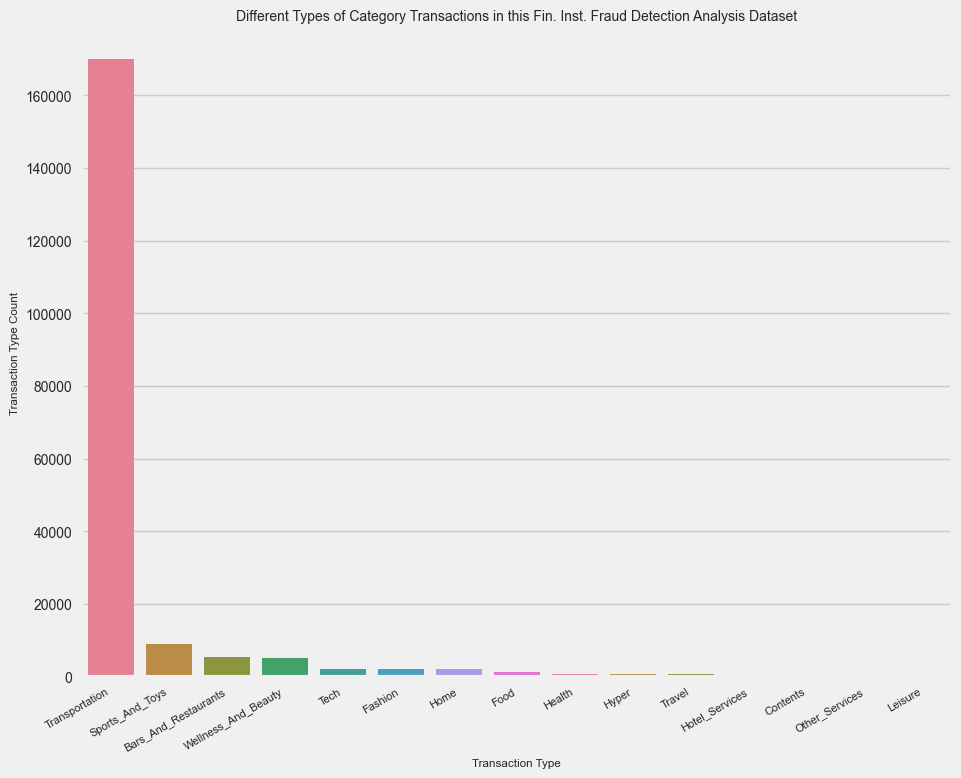

Category
Transportation          169900
Food                      8905
Health                    5384
Wellness_And_Beauty       5100
Fashion                   2188
Bars_And_Restaurants      2108
Hyper                     2092
Sports_And_Toys           1306
Tech                       794
Home                       647
Hotel_Services             568
Other_Services             317
Contents                   286
Travel                     240
Leisure                    165
Name: count, dtype: int64

In [19]:
plt.figure(figsize=(10, 8))
plt.rcParams["font.size"] = 7
sns.barplot(x=df["Category"].unique(), y=df["Category"].value_counts(), palette=sns.color_palette("husl", 8))
plt.xlabel("Transaction Type")
plt.ylabel("Transaction Type Count")
plt.title("Different Types of Category Transactions in this Fin. Inst. Fraud Detection Analysis Dataset")
ax = plt.subplot()
ax.set_xticklabels(list(df["Category"].unique()),
                   rotation=30,
                   fontsize="8",
                   horizontalalignment="right")
plt.show()
df["Category"].value_counts()

C:\Users\andre\AppData\Local\Temp\ipykernel_32424\2824611545.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df["Gender"].unique(), y=df["Gender"].value_counts(), palette=sns.color_palette("husl", 8))
C:\Users\andre\AppData\Local\Temp\ipykernel_32424\2824611545.py:3: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(x=df["Gender"].unique(), y=df["Gender"].value_counts(), palette=sns.color_palette("husl", 8))
C:\Users\andre\AppData\Local\Temp\ipykernel_32424\2824611545.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(df["Gender"].unique()),


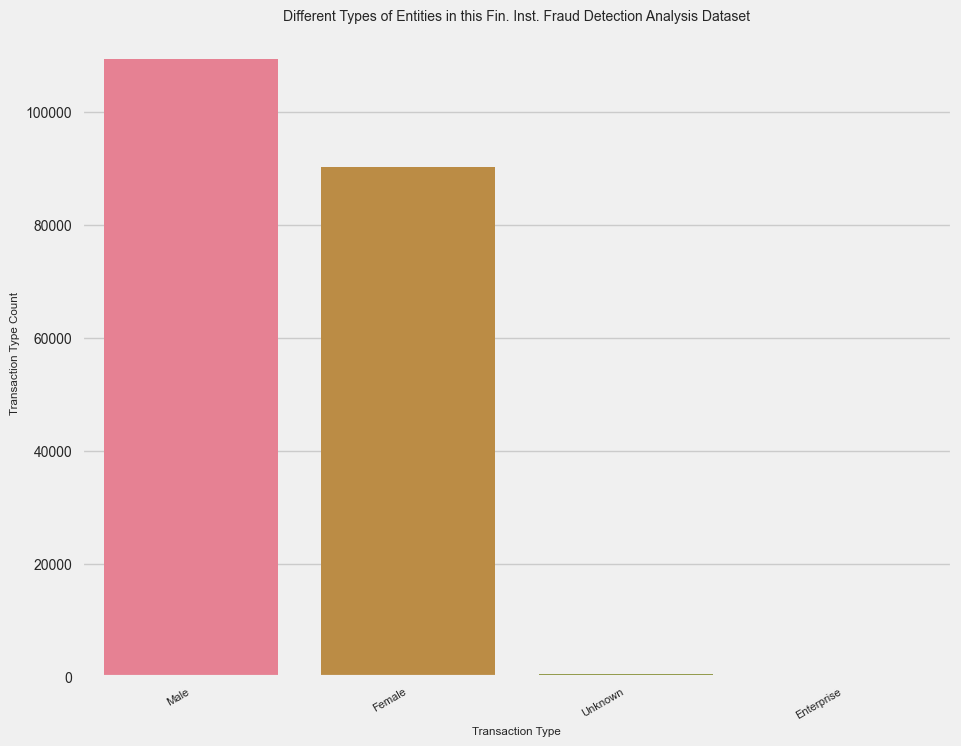

Gender
Female        109264
Male           90181
Enterprise       386
Unknown          169
Name: count, dtype: int64

In [20]:
plt.figure(figsize=(10, 8))
plt.rcParams["font.size"] = 7
sns.barplot(x=df["Gender"].unique(), y=df["Gender"].value_counts(), palette=sns.color_palette("husl", 8))
plt.xlabel("Transaction Type")
plt.ylabel("Transaction Type Count")
plt.title("Different Types of Entities in this Fin. Inst. Fraud Detection Analysis Dataset")
ax = plt.subplot()
ax.set_xticklabels(list(df["Gender"].unique()),
                   rotation=30,
                   fontsize="8",
                   horizontalalignment="right")
plt.show()
df["Gender"].value_counts()

In [21]:
# Set the display precision for floating-point numbers to 3 decimal places
pd.set_option("display.float_format", "{:.2f}".format)
df.loc[:, ["TimeStep", "Amount"]].describe()

,TimeStep,Amount
count,200000.00,200000.00
mean,95.07,37.76
std,51.02,109.52
min,0.00,0.00
25%,52.00,13.77
50%,97.00,26.94
75%,139.00,42.52
max,179.00,7403.44


In [22]:
# Step = Map of unit of time in the real world. 1 step = 1 hour
df["TimeStep"].value_counts()

TimeStep
175    1318
178    1304
177    1297
151    1286
163    1277
       ... 
6       837
7       828
3       818
1       787
2       781
Name: count, Length: 180, dtype: int64

Additionally, I wanted to visualize the counts of all of the different types of continuous entries within each descriptive column as count plots to show the distribution/spread in the graph: TimeStep and Amount.

<Axes: title={'center': 'Distribution of Time Feature'}, xlabel='TimeStep', ylabel='count'>

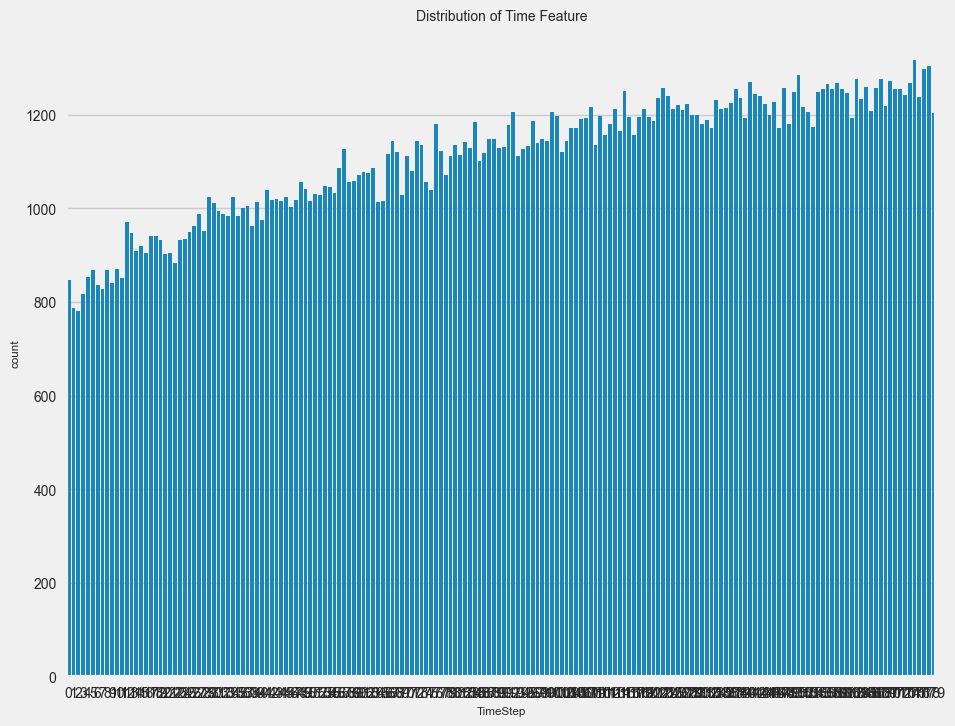

In [23]:
plt.figure(figsize=(10, 8))
plt.rcParams["font.size"] = 7
plt.title('Distribution of Time Feature')
sns.countplot(x="TimeStep", data=df)

In [24]:
df["Amount"].value_counts()

Amount
13.32      61
23.35      57
7.18       57
0.49       57
14.88      57
           ..
127.28      1
105.20      1
201.68      1
5736.56     1
89.20       1
Name: count, Length: 15276, dtype: int64

Note: The number of entries above the filtered amount value of 250 is 1828 (0.91% of total entries).


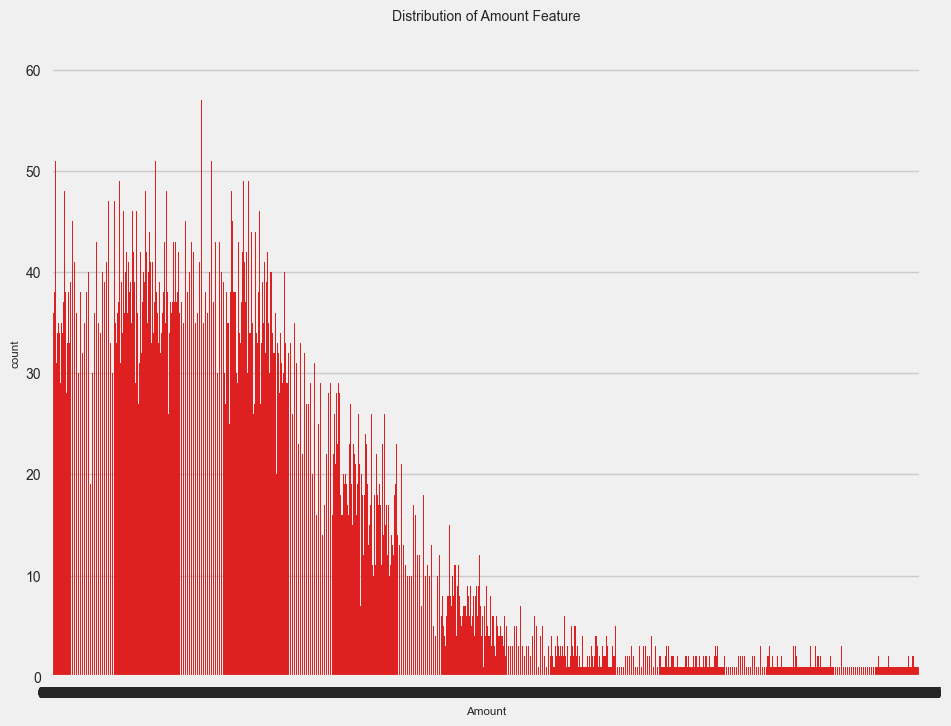

In [25]:
amount_counts = df["Amount"].value_counts()
amount_filter_value: float = 250.00
df_amount_dist_display_sample = df[df["Amount"] <= amount_filter_value]
num_entries_above_amount_filter_value = df[df["Amount"] > amount_filter_value].shape[0]
perc_amount_above_amount_filter_value = (float(num_entries_above_amount_filter_value) / df.shape[0]) * 100
print(f"Note: The number of entries above the filtered amount value of {int(amount_filter_value)} is {num_entries_above_amount_filter_value} \
({perc_amount_above_amount_filter_value:.2f}% of total entries).")
plt.figure(figsize=(10, 8))
plt.rcParams["font.size"] = 7
plt.title('Distribution of Amount Feature')
sns.countplot(x="Amount", data=df_amount_dist_display_sample, color="red")
plt.show()

In [26]:
counts_fraud_col = df["Fraud"].value_counts()
normal_cases, fraud_cases = counts_fraud_col[0], counts_fraud_col[1]
percent_normal = (normal_cases / (normal_cases + fraud_cases)) * 100
percent_fraud = (fraud_cases / (normal_cases + fraud_cases)) * 100
results = f"There were {normal_cases} non-fraudulent transactions ({percent_normal:.3f}%) \
and {fraud_cases} fradulent transactions ({percent_fraud:.3f}%)"
results

'There were 197641 non-fraudulent transactions (98.820%) and 2359 fradulent transactions (1.179%)'

Lastly, I wanted to visualize the counts of all of the different types of entries within the Fraud column as a bar graph to show the spread across the dataset.

C:\Users\andre\AppData\Local\Temp\ipykernel_32424\207855673.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts_fraud_col.index, y=counts_fraud_col, palette=sns.color_palette("husl", 8))
C:\Users\andre\AppData\Local\Temp\ipykernel_32424\207855673.py:3: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.barplot(x=counts_fraud_col.index, y=counts_fraud_col, palette=sns.color_palette("husl", 8))


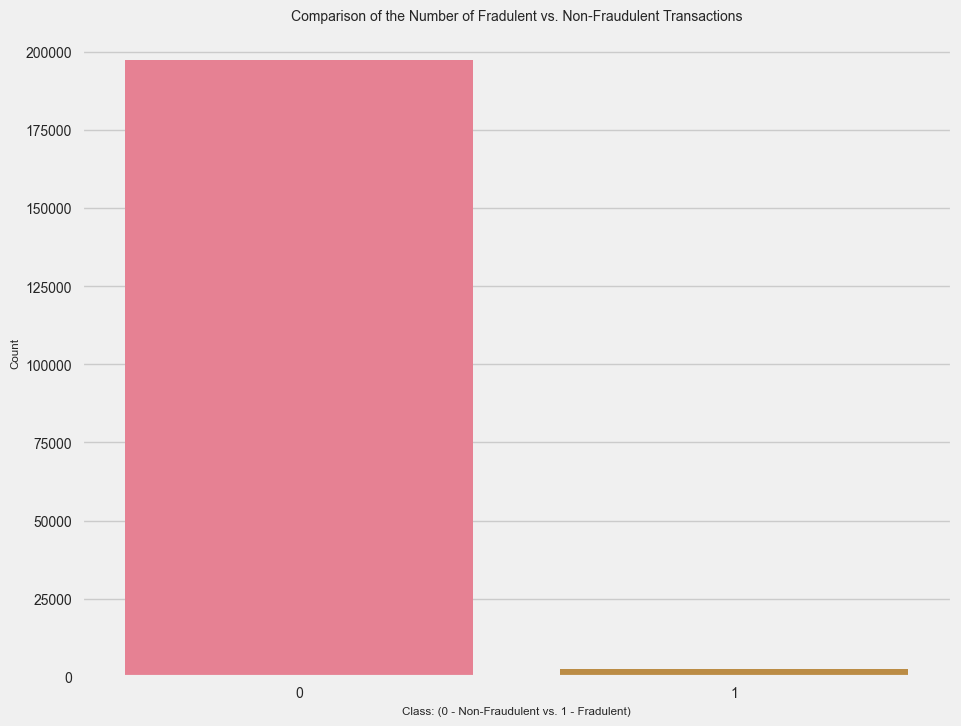

In [27]:
plt.figure(figsize=(10, 8))
plt.rcParams["font.size"] = 7
sns.barplot(x=counts_fraud_col.index, y=counts_fraud_col, palette=sns.color_palette("husl", 8))
plt.title("Comparison of the Number of Fradulent vs. Non-Fraudulent Transactions")
plt.ylabel("Count")
plt.xlabel("Class: (0 - Non-Fraudulent vs. 1 - Fradulent)")
plt.show()

Here are some other notable data analytics I did with the dataset: (1) seeing the mean values across each spending category as well as (2) finding a percentage between the amount of Fraud vs. Non-Fraud cases in each spending category (seeing if there was an indirect correlation potentially that could detriment or support my later Machine Learning findings).

In [28]:
# Printing out the mean values across each category
print("Mean Feature Values per Category")
df_category_grouping_amount_mean = df.groupby('Category')["Amount"].mean()
df_category_grouping_fraud_mean = df.groupby('Category')["Fraud"].mean()
df_mean = pd.concat([df_category_grouping_amount_mean, df_category_grouping_fraud_mean], keys=["Amount", "Fraud"])
df_mean = pd.DataFrame(index=df["Category"].unique())
df_mean = pd.merge(left=df_mean, right=df_category_grouping_amount_mean, how="inner", left_on=df_mean.index, right_on=df_category_grouping_amount_mean.index)
df_mean.rename(columns={"key_0": "Category"}, inplace=True)
df_mean.set_index(keys="Category", drop=True, inplace=True)
df_mean = pd.merge(left=df_mean, right=df_category_grouping_fraud_mean, how="inner", left_on=df_mean.index, right_on=df_category_grouping_fraud_mean.index)
df_mean.rename(columns={"key_0": "Category"}, inplace=True)
df_mean.set_index(keys="Category", drop=True, inplace=True)
df_mean

Mean Feature Values per Category


,Amount,Fraud
Category,,
Transportation,27.00,0.00
Sports_And_Toys,218.29,0.50
Bars_And_Restaurants,42.44,0.02
Wellness_And_Beauty,64.80,0.04
Tech,121.94,0.07
Fashion,63.70,0.02
Home,166.42,0.15
Food,36.68,0.00
Health,137.75,0.11


In [29]:
# Figuring out and displaying the differences between Fraud vs. Non-Fraud Cases 
# in each spending category
df_non_fraud = df[df["Fraud"] == 0]
df_fraud = df[df["Fraud"] == 1]

pd.concat([df_fraud.groupby("Category")["Amount"].mean(), df_non_fraud.groupby("Category")["Amount"].mean(), \
    df.groupby("Category")["Fraud"].mean() * 100], keys=["Fraudulent", "Non-Fradulent", "Percentage (%)"], axis=1, \
    sort=False).sort_values(by=["Non-Fradulent"])

,Fraudulent,Non-Fradulent,Percentage (%)
Category,,,
Transportation,NaN,27.00,0.00
Food,NaN,36.68,0.00
Hyper,173.07,39.68,4.40
Bars_And_Restaurants,120.29,41.20,1.57
Contents,NaN,47.10,0.00
Wellness_And_Beauty,228.53,57.35,4.35
Fashion,229.22,61.09,1.55
Other_Services,311.61,73.49,23.97
Leisure,295.65,75.69,92.12


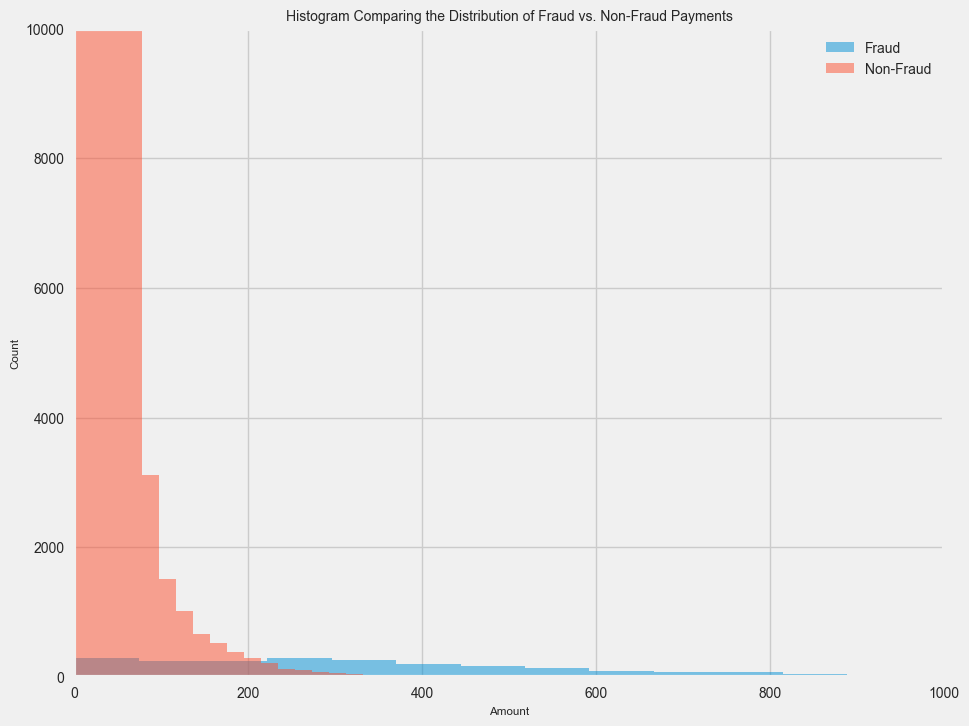

In [30]:
# Plot histograms of the amounts in fraud and non-fraud data
plt.figure(figsize=(10, 8))
plt.rcParams["font.size"] = 7
hist_bins: int = 100
plt.hist(df_fraud["Amount"], alpha=0.5, label="Fraud", bins=hist_bins)
plt.hist(df_non_fraud["Amount"], alpha=0.5, label="Non-Fraud", bins=hist_bins)
plt.title("Histogram Comparing the Distribution of Fraud vs. Non-Fraud Payments")
plt.xlabel("Amount")
plt.ylabel("Count")
plt.xlim(0, 1000)
plt.ylim(0, 10000)
plt.legend()
plt.show()

Just before I move onto the Machine Learning section of this report, I wanted to clean up some last things with the dataset such as removing unnecessary columns in the current dataframe, rounding numerical columns for readability, and factorizing (integer-assigning) categorical columns into numerical ones to feed as factors while doing Machine Learning.

In [31]:
# Removed unnecessary columns not needed for Machine Learning analysis
df.drop(labels=["Customer", "ZipCodeOrig", "Merchant", "ZipMerchant"], axis=1, inplace=True)
df

,TimeStep,Age,Gender,Category,Amount,Fraud
70803,26,3,Male,Transportation,11.65,0
470791,146,1,Female,Transportation,1.60,0
568310,172,3,Female,Transportation,33.36,0
23709,9,2,Male,Transportation,8.01,0
49723,19,3,Female,Transportation,38.11,0
...,...,...,...,...,...,...
363474,116,4,Male,Food,14.83,0
570570,173,5,Female,Transportation,14.11,0
136543,48,5,Female,Transportation,43.26,0
203448,69,4,Male,Transportation,7.59,0


In [32]:
# Round the Amount column appropriately (for readability)
df["Amount"] = df["Amount"].round(2)
df

,TimeStep,Age,Gender,Category,Amount,Fraud
70803,26,3,Male,Transportation,11.65,0
470791,146,1,Female,Transportation,1.60,0
568310,172,3,Female,Transportation,33.36,0
23709,9,2,Male,Transportation,8.01,0
49723,19,3,Female,Transportation,38.11,0
...,...,...,...,...,...,...
363474,116,4,Male,Food,14.83,0
570570,173,5,Female,Transportation,14.11,0
136543,48,5,Female,Transportation,43.26,0
203448,69,4,Male,Transportation,7.59,0


In [33]:
df["Category"].value_counts()

Category
Transportation          169900
Food                      8905
Health                    5384
Wellness_And_Beauty       5100
Fashion                   2188
Bars_And_Restaurants      2108
Hyper                     2092
Sports_And_Toys           1306
Tech                       794
Home                       647
Hotel_Services             568
Other_Services             317
Contents                   286
Travel                     240
Leisure                    165
Name: count, dtype: int64

In [34]:
# Convert any needed categorical columns into numerical ones via factorizing (integer mapping)
for col in df.columns:
    if not pd.api.types.is_numeric_dtype(df[col]):
        df[col] = pd.factorize(df[col])[0]

In [35]:
df

,TimeStep,Age,Gender,Category,Amount,Fraud
70803,26,3,0,0,11.65,0
470791,146,1,1,0,1.60,0
568310,172,3,1,0,33.36,0
23709,9,2,0,0,8.01,0
49723,19,3,1,0,38.11,0
...,...,...,...,...,...,...
363474,116,4,0,7,14.83,0
570570,173,5,1,0,14.11,0
136543,48,5,1,0,43.26,0
203448,69,4,0,0,7.59,0


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 70803 to 577977
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   TimeStep  200000 non-null  int64  
 1   Age       200000 non-null  int64  
 2   Gender    200000 non-null  int64  
 3   Category  200000 non-null  int64  
 4   Amount    200000 non-null  float64
 5   Fraud     200000 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 10.7 MB


As all of the data in the working dataframe is now numerical, I wanted to preliminary-wise see the quantifiable correlation between the `Fraud` column and the rest in the dataset. Thus, using the `corr` function for dataframes with the `Fraud` column, I created a heatmap and bar-graph visualizing the constrast between each financial institution entries' attribute columns and its Fraud value.

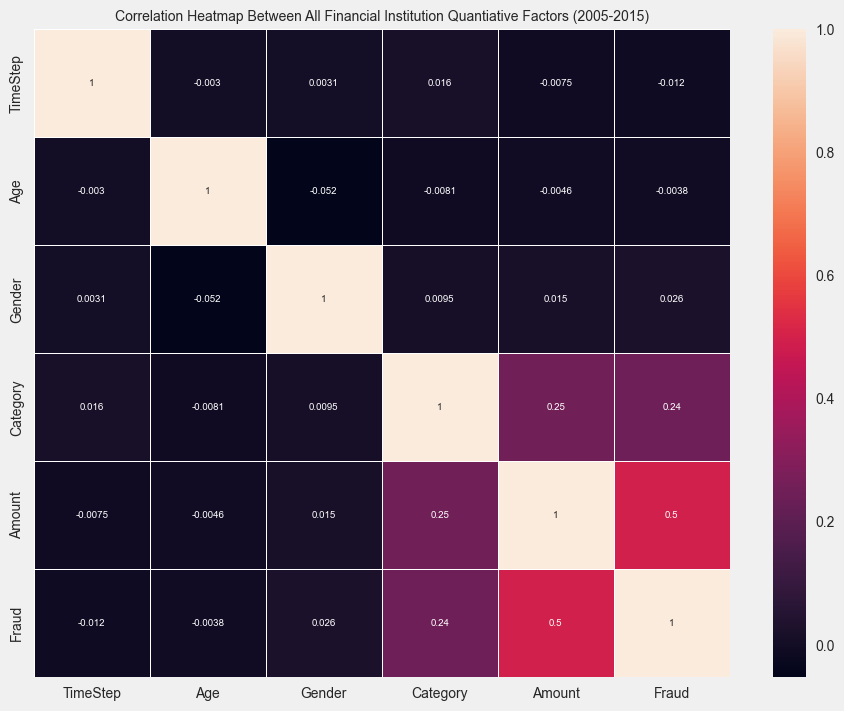

C:\Users\andre\AppData\Local\Temp\ipykernel_32424\3111820026.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_corr.index[1:], y=target_corr.values[1:], palette=sns.color_palette("husl", 8))
C:\Users\andre\AppData\Local\Temp\ipykernel_32424\3111820026.py:12: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  sns.barplot(x=target_corr.index[1:], y=target_corr.values[1:], palette=sns.color_palette("husl", 8))


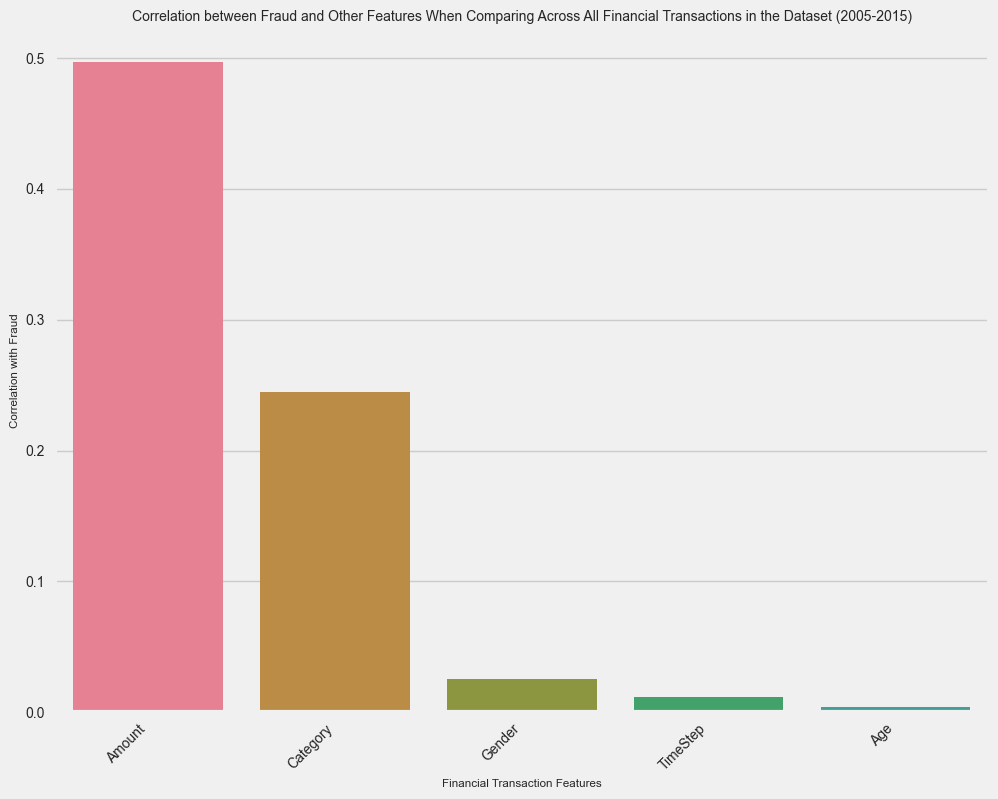

In [37]:
# Correlation heatmap to quantify relationships between financial transaction attributes
plt.figure(figsize=(10, 8))
plt.rcParams["font.size"] = 7
sns.heatmap(df.corr(), annot=True, linewidths=0.5)
plt.title("Correlation Heatmap Between All Financial Institution Quantiative Factors (2005-2015)")
plt.show()

# Correlation bar graph between Fraud and all other financial transaction attributes
target_corr = df.corr()["Fraud"].abs().sort_values(ascending=False)
plt.figure(figsize=(10, 8))
plt.rcParams["font.size"] = 7
sns.barplot(x=target_corr.index[1:], y=target_corr.values[1:], palette=sns.color_palette("husl", 8))
plt.xticks(rotation=45, ha="right")
plt.xlabel("Financial Transaction Features")
plt.ylabel("Correlation with Fraud")
plt.title("Correlation between Fraud and Other Features When Comparing Across All Financial Transactions in the Dataset (2005-2015)")
plt.tight_layout()
plt.show()

In [38]:
df = df.drop(["TimeStep"], axis=1)
df

,Age,Gender,Category,Amount,Fraud
70803,3,0,0,11.65,0
470791,1,1,0,1.60,0
568310,3,1,0,33.36,0
23709,2,0,0,8.01,0
49723,3,1,0,38.11,0
...,...,...,...,...,...
363474,4,0,7,14.83,0
570570,5,1,0,14.11,0
136543,5,1,0,43.26,0
203448,4,0,0,7.59,0


## Machine Learning - Model Training and Evaluation

Great, now we are onto the Machine Learning part of the blog post!

Since the dataframe is now properly cleaned, sorted, and integer-mapped by this point, I had split the respective dataframe into the train and test datasets for the Machine Learning model with 80% going to the training dataset and the last 20% going to the test dataset. Fortunately, because order of the data sequentially does not matter here, I was able to utilize the `train_test_split` function for shuffling and randomization, making the future-generated Machine Learning model more unpredictable but also more objective in its returned model results. 

Note that here I also used a `Pipeline` object from the `scikit-learn` package as well as the `StandardScaler` classes. The `StandardScaler` class is useful for apply Z-score normalization / transformation on the data to avoid sensivite-prone Machine Learning algorithms which require appropriate scaling of the features within its trained dataset. As I learned from online, this `Pipeline` object is necesary to ensure appropriate preprocessing just before the dataset is passed to the Machine Learning model for training and later evaluation. 

In [39]:
X = df.drop(["Fraud"], axis=1)
y = df["Fraud"]

print("X Shape:", X.shape)
print("Y Shape:", y.shape)

pipeline = Pipeline([
    ("std_scaler", StandardScaler())
])

X_scaled = pipeline.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=True, random_state=42)

X Shape: (200000, 4)
Y Shape: (200000,)


Due to the higher-order dimensionality in the `X` columns, I had to utilze `PCA` to reduce the `X` columns in the dataset down to a manageable amount for humans (most accepted is `2` principal components).

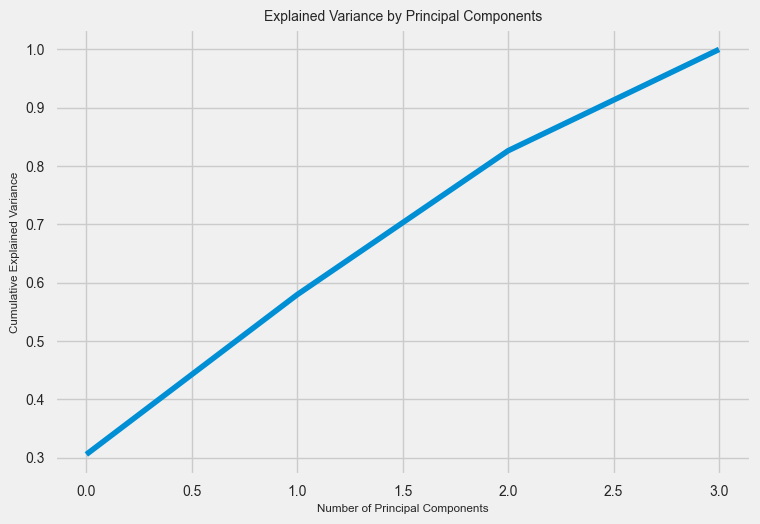

In [40]:
# Used PCA to lower the dimensionality of the dataset used later for Machine
# Learning (training and testing)
pca = PCA()
principal_components = pca.fit_transform(X_test)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Explained Variance by Principal Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()

In [41]:
# Created a new dataframe containing the 2 main principal components used in the
# later Machine Learning section of this blog-post
pca_df = pd.DataFrame(data=principal_components[:, :2], columns=["PC1", "PC2"])
pca_df

,PC1,PC2
0,-0.60,-0.69
1,-0.27,1.19
2,-0.39,0.14
3,-0.17,1.72
4,-0.20,-0.20
...,...,...
39995,-0.22,-0.20
39996,-0.56,-0.69
39997,-0.58,-0.69
39998,6.55,-0.24


In [42]:
y_test.value_counts()

Fraud
0    39527
1      473
Name: count, dtype: int64

Adding in the `y` column (`"Fraud"`) to this modified dataframe containing two new `PCA` components, we are able to experimentally look at some basic labeling of the data prior to clustering. 

*(Disclaimer: I realize that clustering is considered unsupervised Machine Learning. The experimental practices of labels here are merely for reference to anticipate future clustering patterns. In real clustering applications, I realize that I wouldn't really have the labels to cluster in the first place. As seen throughout this section, this practice doesn't intend to skew my Machine Learning methods.)*

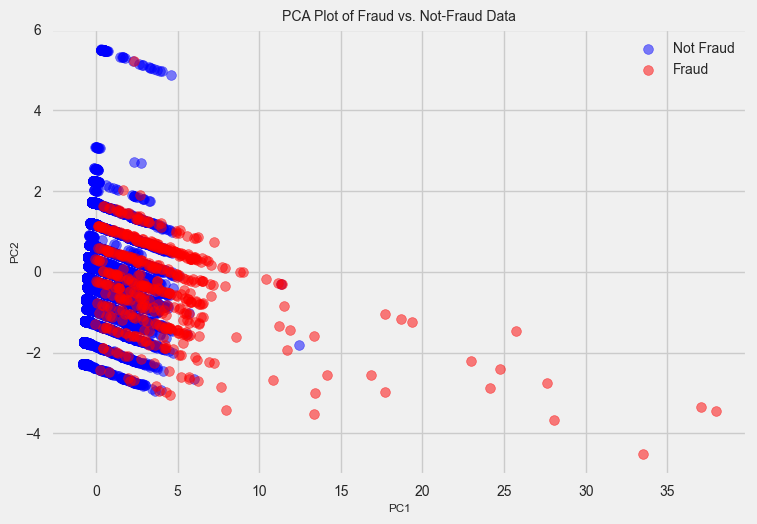

In [43]:
# Add the "Fraud" column to the PCA DataFrame
pca_df["Fraud"] = y_test.values

# Separate the data based on the "Fraud" column
fraud_points = pca_df[pca_df["Fraud"] == 1]
not_fraud_points = pca_df[pca_df["Fraud"] == 0]

# Visualize "fraud" and "not fraud" PCA data
plt.scatter(not_fraud_points["PC1"], not_fraud_points["PC2"], c='blue', label='Not Fraud', alpha=0.5)
plt.scatter(fraud_points["PC1"], fraud_points["PC2"], c='red', label='Fraud', alpha=0.5)

plt.title("PCA Plot of Fraud vs. Not-Fraud Data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

Leading into the DBSCAN analysis, we will do an exploratory K-Means Clustering to see if we detect any patterns or correlations in the dataset between `Fraud` and other categories that were reported with the existing financial transactions.

c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

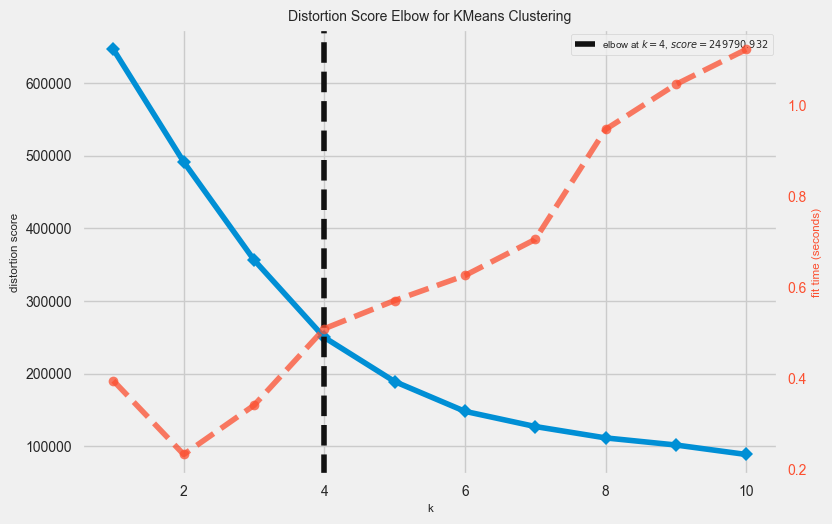

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [44]:
# Using the KElbowVisualizer to determine the appropriate number of clusters
# to use in the K-Means algorithm
kmeans_model = KMeans()
kmeans_elbow_visualizer = KElbowVisualizer(kmeans_model, k=(1, 11))
kmeans_elbow_visualizer.fit(X_train)
kmeans_elbow_visualizer.show()

c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


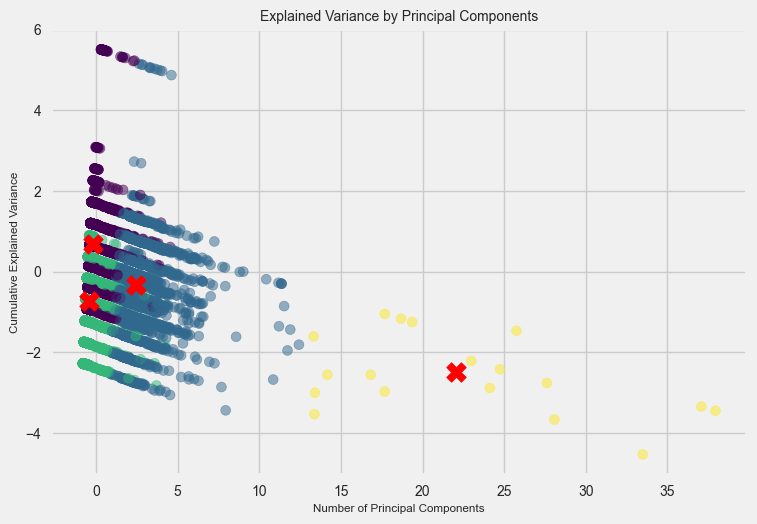

In [45]:
# Complete K-Means Clustering to find any clustering relationships in dataset
# Run the K-Means model on scaled data
kmeans_model = KMeans(n_clusters=4, random_state=42).fit(X_train)

# Get the cluster number for each datapoint
X_clusters = kmeans_model.predict(X_test)

# Save the cluster centroids
X_clusters_centers = kmeans_model.cluster_centers_

# Plot PCA and K-Means cluster centers
X_test_principal_clusters_centers = pca.transform(X_clusters_centers)
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=X_clusters, cmap='viridis', s=50, alpha=0.5)
plt.scatter(X_test_principal_clusters_centers[:, 0], X_test_principal_clusters_centers[:, 1], c='red', marker='X', s=200, label='Cluster Centers')
plt.title("Explained Variance by Principal Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()

In [46]:
# Obtain predictions and calculate distance from cluster centroid (using Euclidean Distance)
kmeans_dist = [np.linalg.norm(x - y) for x, y in zip(X_test, X_clusters_centers[X_clusters])]

y_pred = np.array(kmeans_dist)
y_pred[kmeans_dist >= np.percentile(kmeans_dist, 95)] = 1
y_pred[kmeans_dist < np.percentile(kmeans_dist, 95)] = 0
y_pred

array([0., 0., 0., ..., 0., 1., 0.])

ROC AUC Score: 81.49%
_______________________________________________
CLASSIFICATION REPORT:
                 0      1  accuracy  macro avg  weighted avg
precision     1.00   0.16      0.95       0.58          0.99
recall        0.96   0.67      0.95       0.81          0.95
f1-score      0.98   0.26      0.95       0.62          0.97
support   39527.00 473.00      0.95   40000.00      40000.00
_______________________________________________
Confusion Matrix:
[[37845  1682]
 [  155   318]]


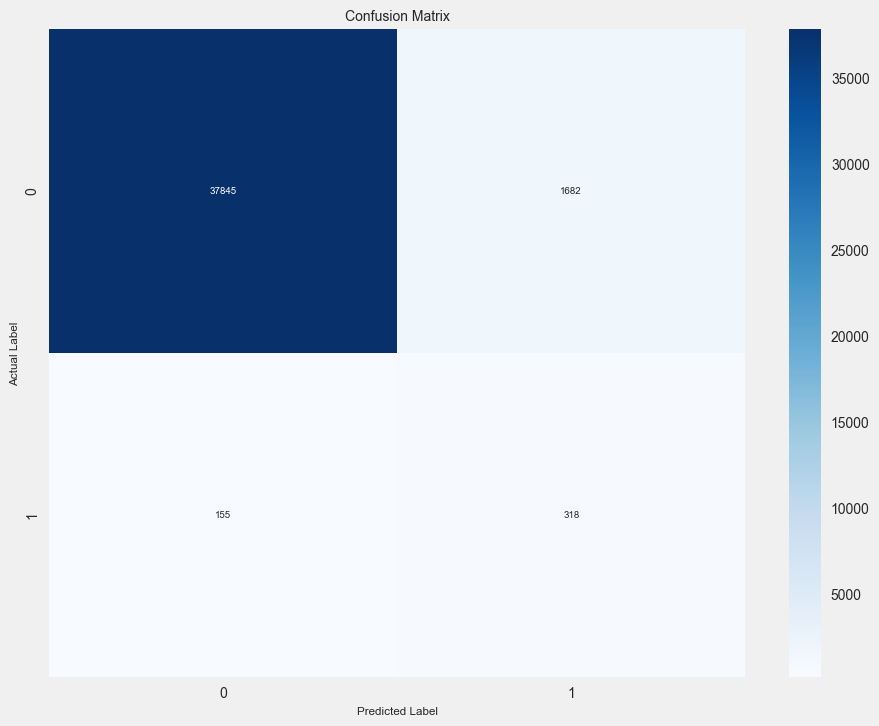

In [47]:
# Display the accuracy statistics and the confusion matrix of the K-Means algorithm 
# cluster predictions
clf_report = pd.DataFrame(classification_report(y_true=y_test, y_pred=y_pred, output_dict=True, zero_division=0))
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

print(f"ROC AUC Score: {roc_auc_score(y_true=y_test, y_score=y_pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{clf_report}")
print("_______________________________________________")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.rcParams["font.size"] = 7
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

Now to the main focus: the `DBSCAN` analysis. We use the `NearestNeighbor` algorithm, originally intended to implement for neighbor searching in unsupervised settings, to find the optimal parameters for the `DBSCAN` analysis. `DBSCAN` here is necessary because it bulk-computes all neighborhood queries and is super effective in finding outliers within supposed clusters, answering the original question in the first place of anomaly detection.

In [48]:
# Methodical way to find an appropriate number for the DBSCAN `min_samples` argument
dbscan_min_samples = 2 * (X.shape[1])
dbscan_min_samples

8

In [49]:
# Completing NearestNeighbors algorithm to find the appropriate `eps` (epsilon value)
# from the y-coordinate of the inflection point (methodical way)
nn_model = NearestNeighbors(n_neighbors=dbscan_min_samples)
nn_model_fit = nn_model.fit(X_test)
nn_distances, nn_indices = nn_model_fit.kneighbors(X_test)

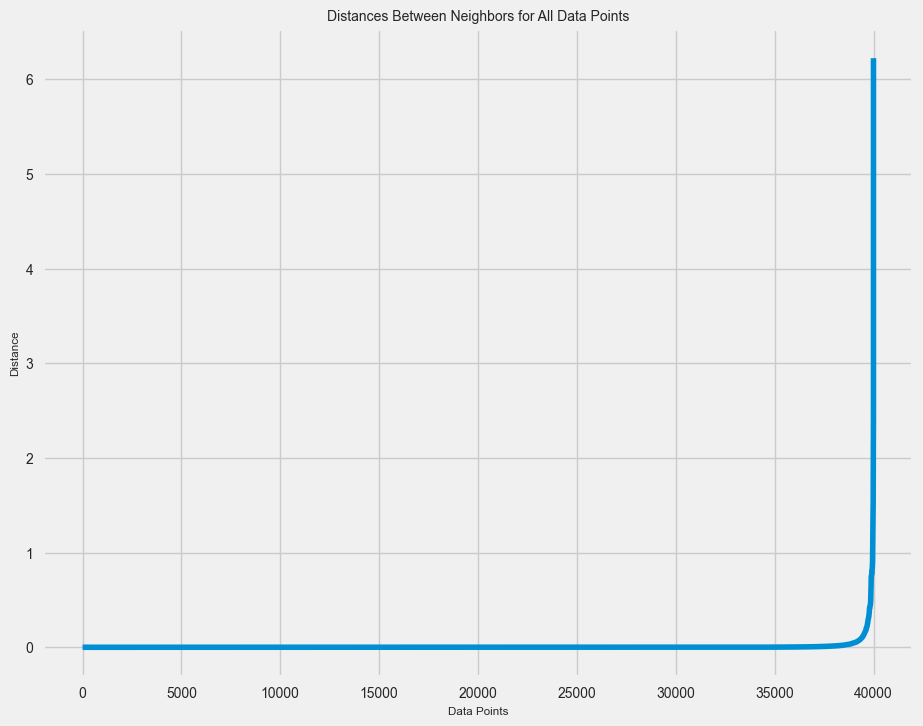

In [50]:
# Plot the (sorted) NearestNeighnor distances between groups of points
nn_distances = np.sort(nn_distances, axis=0)
nn_distances = nn_distances[:, 1]
plt.figure(figsize=(10, 8))
plt.rcParams["font.size"] = 7
plt.plot(nn_distances)
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.title("Distances Between Neighbors for All Data Points")
plt.show()

In [51]:
# Defining the inflection point (x, y) using the Kneed package
kneedle_model = kneed.KneeLocator(y=nn_distances, x=np.arange(0, X_test.shape[0]), 
                                  S=1.0, curve="convex", direction="increasing")
nn_model_inflection_point = [kneedle_model.knee, kneedle_model.knee_y]
nn_model_inflection_point

[39816, 0.4188503437268385]

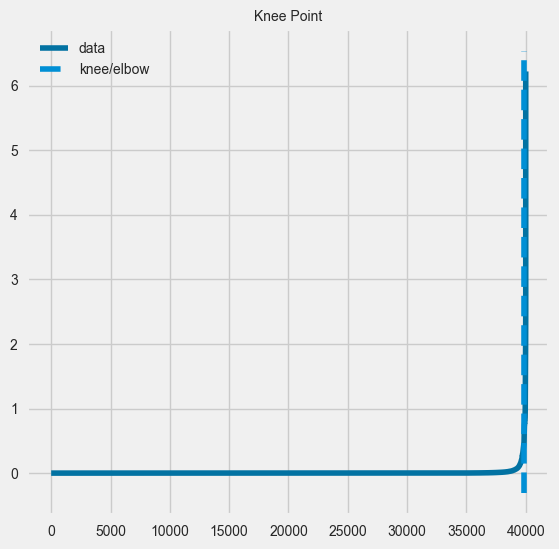

In [52]:
# Visualizing the kneedle model
kneedle_model.plot_knee()

In [53]:
df["Fraud"].value_counts()

Fraud
0    197641
1      2359
Name: count, dtype: int64

In [54]:
# Methodical way of getting the `eps` argument for DBSCAN
rounded_nn_model_inflection_point_y_coord = round(nn_model_inflection_point[1], 2)
rounded_nn_model_inflection_point_y_coord

0.42

In [55]:
# Apply PCA to reduce dimensionality
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Apply DBSCAN to the reduced-dimensional training data
dbscan = DBSCAN(eps=rounded_nn_model_inflection_point_y_coord, min_samples=dbscan_min_samples)
dbscan.fit(X_train_pca)

# Apply DBSCAN to the reduced-dimensional testing data
labels_test = dbscan.fit_predict(X_test_pca)

Finally, we can conclude the build-up of setting up and executing `DBSCAN` to visualize the `"outlier"` points of the dataset (i.e. the `Fraud` points across all financial transactions). This illustrates the extent of the anomalies detected across this dataset. Even though it marks a great deal of the dataset points as `Fraud` in this `DBSCAN`, we are able to validate the legitimacy of this with the `KMeans` analysis done above, showing similar projections as described here.

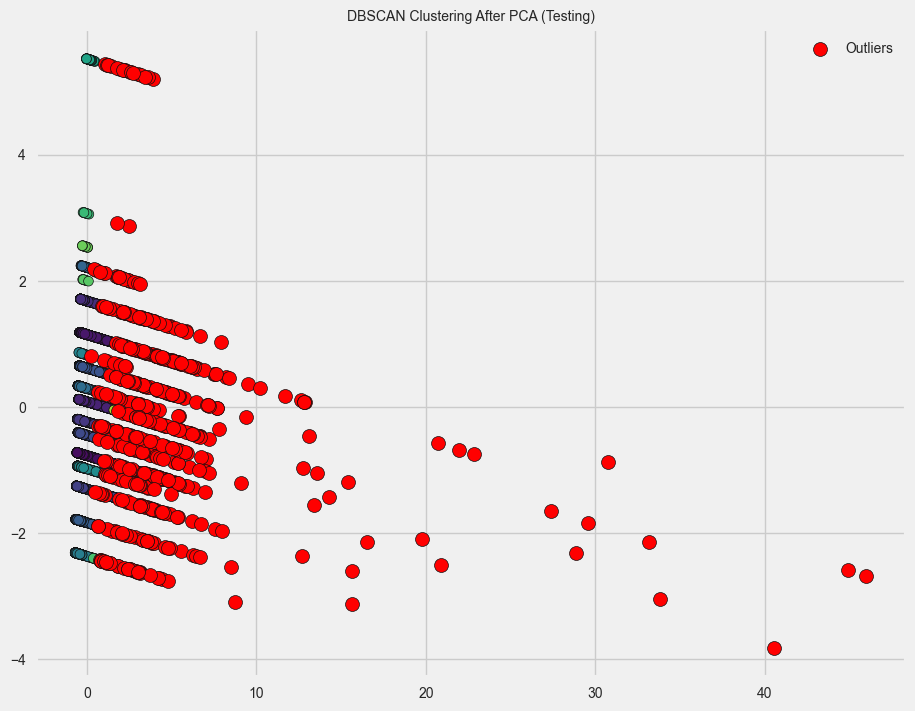

In [56]:
# Visualize the DBSCAN results on the testing data
plt.figure(figsize=(10, 8))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=labels_test, edgecolors='k', cmap='viridis')

# Highlight outliers (those labeled as -1 by DBSCAN)
outliers_mask_test = (labels_test == -1)
plt.scatter(X_test_pca[outliers_mask_test, 0], X_test_pca[outliers_mask_test, 1], c='red', edgecolors='k', s=100, label='Outliers')

plt.title('DBSCAN Clustering After PCA (Testing)')
plt.legend()
plt.show()

## Conclusions

- Looking at the clustering final results, I found that the overall Machine Learning methods of using `DBSCAN` and `K-Means Clustering` together in the models to be mostly effective in detecting cases of fraud vs. legitimate financial institution (i.e. bank) transactions when comparing against the objective testing datasets. The rationale of executing the `K-Means` algorithm in this blog-post is to use that as an approximate benchmark to compare against the effectivness of `DBSCAN` in detecting cases of fraud via clustering. After visual inspection, I can safely justify my previous claims and recommend this be used to classify any basic causes of financial institution fraud in future applications.

- In terms of expanding the scope of this blog-post, I would have taken this further by trying to determine if there are specific factors in the entries marked as financial-institutional fraud that more strongly correlate with fraud-like behavior. This will be effective in making potentially more secure fraud-protected systems which guard against these factors.

- Seeing how I a great deal of issues with DBSCAN, due to algorithmic complexity within the iternals of this Machine Learning technique, for outlier detection, I will most likely be careful of using this technique in the future if I ever need to anomaly or outlier detection as this is listed on many reputable resources for being inefficient. Sure, the effectiveness of this unsupervised technique cannot be overstated as it does not need any previous labeling to cluster appropriately. However, I will only use this technique with smaller-sized datasets and be aware that if I must use DBSCAN in the future, I will perform careful hyperparameter tuning (balancing the `eps` and `min_samples` arguments) and complete dimensionality reduction before calling DBSCAN with `PCA` to ensure the most ideal results (or at least results that do not time-out due to GPU resource constraints).

- Ultimately, I learned a great deal from the blog post experience as I now better understand how to properly utilize `DBSCAN` and perform outlier or anomaly detection techniques, which are unsupervised classification method of Machine Learning, in order to find relationships between groups of data and infer conclusions about any potential trends, through applying it to a practical, every-day dilemma in our society. Even though the datasets in the real world are never this simple to analyze, I hope to utilize in future contexts as this was an interesting case study to analyze given its real-life implications in modern financial security systems.

## Reference Sources and Citations (IEEE Format)

To complete this blog post, I used the following online sources as references for developing this:

[1] BankSim Payments Simulator - Fraud Detection Dataset:

- E. Lopez-Rojas. "Synthetic Data From a Financial Payment System", 2015. [Online]. Available: https://www.kaggle.com/datasets/ealaxi/banksim1. [Accessed 15-Nov.-2023].

[2] KMeans Elbow Reference: 

- F. Javier Gallego, "Outliers+EDA+Clustering Tutorial", Jul.-2022. [Online]. Available: https://www.kaggle.com/code/javigallego/outliers-eda-clustering-tutorial. [Accessed 16-Nov.-2023].

[3] KMeans Reference:

- M. Isbaine, "Fraud Detection", 2021. [Online]. Available: https://www.kaggle.com/code/mohamedisbaine/fraud-detection. [Accessed 16-Nov.-2023].

[4] NearestNeighbor, KNeedle, DBSCAN Reference: 

- R. De Menezes Gomes, "Fraud Detection - Clustering with DBSCAN", Jan.-2023. [Online.] Available: https://www.kaggle.com/code/rodmnzs/fraud-detection-clustering-with-dbscan. [Accessed 15-Nov.-2023].

[5] DBSCAN Reference #2: 

- D. Valeti,  "DBSCAN Algorithm for Fraud Detection & Outlier Detection in a Data Set", 18-Oct.-2021. [Online]. Available: https://medium.com/@dilip.voleti/dbscan-algorithm-for-fraud-detection-outlier-detection-in-a-data-set-60a10ad06ea8. [Accessed 15-Nov.-2023].

[6] Seaborne Color Palette Reference: 

- Seaborn, "Choosing Color Palettes". [Online]. Available: https://seaborn.pydata.org/tutorial/color_palettes.html. [Accessed 16-Nov.-2023].
